## Importing the libraries

In [7]:
import joblib
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator

## Dataset Visualization

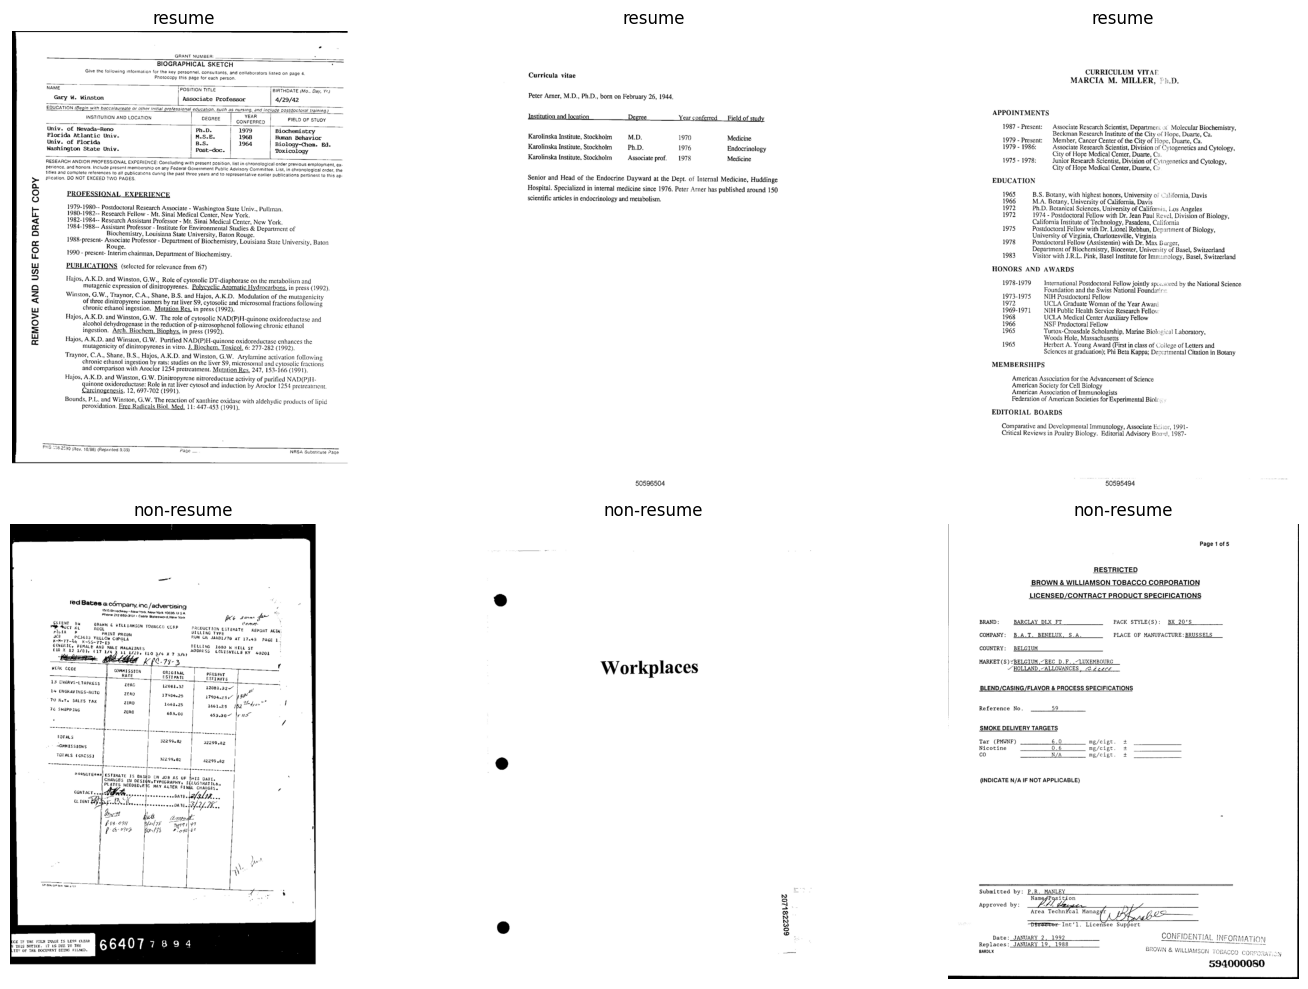

In [8]:
import os
import cv2
import matplotlib.pyplot as plt

train_folder = '/kaggle/input/dataset-assignment/train'

subfolders = ['resume', 'non-resume']

num_rows = len(subfolders)
num_cols = 3  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for row, subfolder in enumerate(subfolders):
    subfolder_path = os.path.join(train_folder, subfolder)
    
    files = os.listdir(subfolder_path)
    
    for col in range(num_cols):
        file = files[col] if col < len(files) else None
        
        if file:
            file_path = os.path.join(subfolder_path, file)
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            axes[row, col].imshow(image)
            axes[row, col].set_title(f'{subfolder}')
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()


## Data Augmentation
Taking in parameters for batch size, target image height, and width, the function leverages the Keras ImageDataGenerator to apply essential data augmentations, including rotation, width and height shifts, zoom, and horizontal flips, enhancing model robustness and generalization. The function assumes a directory structure for training, testing, and validation datasets and generates respective data iterators. Users can easily integrate this function into their image classification pipelines by specifying image dimensions and batch size.

In [9]:
def dataflow_(batch_size, img_h, img_w):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,  
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True)
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    valid_datagen = ImageDataGenerator(rescale=1./255)
    
    train_it = train_datagen.flow_from_directory('/kaggle/input/dataset-assignment/train/',batch_size=batch_size,target_size=(img_h, img_w))
    test_it = test_datagen.flow_from_directory('/kaggle/input/dataset-assignment/test/',batch_size=batch_size,target_size=(img_h, img_w))
    valid_it = valid_datagen.flow_from_directory('/kaggle/input/dataset-assignment/val/', batch_size=batch_size,target_size=(img_h,img_w))
    
    return train_it,test_it,valid_it

In [10]:
train_it,test_it,valid_it = dataflow_(32,256,256)

Found 48392 images belonging to 2 classes.
Found 13142 images belonging to 2 classes.
Found 29393 images belonging to 2 classes.


## **TRANFER LEARNING WITH INITIALIZED VGG**

![Modified VGG16 Model Architecture](https://www.researchgate.net/profile/Daegyun-Choi/publication/350828239/figure/fig1/AS:1017585780924416@1619622764106/Architecture-of-the-modified-VGG16-model.ppm)

VGG16,  is a convolutional neural network (CNN) architecture designed for image classification. The "16" in VGG16 refers to the 16 weight layers it consists of. VGG16 is known for its simplicity and uniform architecture, featuring small convolutional filters (3x3) with a stride of 1 and max-pooling layers (2x2) with a stride of 2. This architecture, while deeper than previous models like AlexNet, maintains a straightforward and easy-to-understand structure.

1. Transfer Learning Performance: The pre-trained VGG16 model, which has been trained on the ImageNet dataset, has demonstrated strong performance in image classification tasks. This pre-training allows for effective transfer learning on new datasets with relatively small amounts of data.

2. Availability and Popularity: VGG16 is well-established and widely used in the deep learning community. Pre-trained VGG16 models are readily available in popular deep learning frameworks, making it accessible for transfer learning applications.

3. Feature Extraction: The convolutional layers of VGG16 act as powerful feature extractors, capturing important visual features from images. This makes it useful for transfer learning in tasks such as object recognition, detection, and segmentation.

In [11]:
from keras import applications
from keras.optimizers import Adam
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers import GlobalAveragePooling2D

img_width, img_height = 256,256
model =keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [14]:
def model_layers(model):
    x = model.output
    x = Flatten()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation="relu")(x)
    predictions = Dense(2, activation="sigmoid")(x)
    model_final = Model(inputs = model.input, outputs = predictions)
    
    model_final.compile(loss = "binary_crossentropy", optimizer =Adam(learning_rate=0.0001), metrics=["accuracy",keras.metrics.Recall(),keras.metrics.Precision()])
    model_final.summary()
    return model_final

In [15]:
for layer in model.layers:
    layer.trainable=True 
model_final=model_layers(model)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

## Model Training
In the provided code snippet, two key callbacks are set up for model training:

1. ReduceLROnPlateau: This callback reduces the learning rate if the validation loss stops improving, with the parameters configured to monitor validation loss, patience of 2 epochs, and a minimum learning rate of 0.000001. This aids in optimizing the model's learning rate to potentially improve convergence and prevent overshooting the minimum.

2. ModelCheckpoint: This callback saves the model as a file named 'model_1.h5' if the model's accuracy on the validation set improves. This prevents overfitting by saving the best version of the model based on validation accuracy.

These callbacks help streamline the model training process and enhance model performance by adjusting the learning rate and saving the best-performing model.

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001)
mcp_save = ModelCheckpoint('model_1.hdf5', save_best_only=True, monitor='accuracy', mode='max')

In [17]:
model_final.fit(
train_it,
steps_per_epoch =150,
epochs=10,    
validation_data=valid_it,
validation_steps = 150,
callbacks=[reduce_lr,mcp_save])

Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9346 - recall: 0.9352 - precision: 0.9335

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 205s 1s/step - loss: 0.2218 - accuracy: 0.9346 - recall: 0.9352 - precision: 0.9335 - val_loss: 0.1807 - val_accuracy: 0.9375 - val_recall: 0.9375 - val_precision: 0.9375 - lr: 1.0000e-04
Epoch 2/10
150/150 [==============================] - 174s 1s/step - loss: 0.1920 - accuracy: 0.9379 - recall: 0.9383 - precision: 0.9379 - val_loss: 0.1580 - val_accuracy: 0.9375 - val_recall: 0.9375 - val_precision: 0.9375 - lr: 1.0000e-04
Epoch 3/10
150/150 [==============================] - 169s 1s/step - loss: 0.1892 - accuracy: 0.9350 - recall: 0.9352 - precision: 0.9348 - val_loss: 0.1458 - val_accuracy: 0.9390 - val_recall: 0.9383 - val_precision: 0.9419 - lr: 1.0000e-04
Epoch 4/10
150/150 [==============================] - 165s 1s/step - loss: 0.1724 - accuracy: 0.9362 - recall: 0.9373 - precision: 0.9365 - val_loss: 0.1715 - val_accuracy: 0.9454 - val_recall: 0.9508 - val_precision: 0.9377 - lr: 1.0000e-04
Epoch 5/10
150/150 [=======================

In [18]:
model_final.load_weights('/kaggle/working/model_1.hdf5')

In [33]:
score1 = model_final.evaluate_generator(test_it, steps=len(test_it)//32,workers=2, use_multiprocessing=True)

/tmp/ipykernel_42/3329691827.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score1 = model_final.evaluate_generator(test_it, steps=len(test_it)//32,workers=2, use_multiprocessing=True)


In [36]:
print("The accuracy for model-Pretrained vgg-16 initiazlied with image net:",score1[1]*100,"%")
print("The recall for model-Pretrained vgg-16 initiazlied with image net:",score1[2]*100,"%")
print("The precision for model-Pretrained vgg-16 initiazlied with image net:",score1[3]*100,"%")

The accuracy for model-Pretrained vgg-16 initiazlied with image net: 95.57291865348816 %
The recall for model-Pretrained vgg-16 initiazlied with image net: 94.79166865348816 %
The precision for model-Pretrained vgg-16 initiazlied with image net: 95.78947424888611 %


## Confusion Matrix

A confusion matrix is a tool used in the field of machine learning and statistics to assess the performance of a classification model. It is particularly useful in evaluating the performance of supervised learning algorithms, where the model is trained to classify instances into predefined categories or classes.

The confusion matrix is a matrix layout that visualizes the performance of a classification model by comparing the actual and predicted classes for a set of data. It consists of four main components:

1. **True Positive (TP):** This represents the number of instances that were correctly predicted as belonging to the positive class (e.g., correctly identified as "positive" when they are actually "positive").

2. **True Negative (TN):** This represents the number of instances that were correctly predicted as belonging to the negative class (e.g., correctly identified as "negative" when they are actually "negative").

3. **False Positive (FP) (Type I error):** This represents the number of instances that were incorrectly predicted as belonging to the positive class (e.g., incorrectly identified as "positive" when they are actually "negative").

4. **False Negative (FN) (Type II error):** This represents the number of instances that were incorrectly predicted as belonging to the negative class (e.g., incorrectly identified as "negative" when they are actually "positive").

The confusion matrix provides a comprehensive summary of the model's performance, allowing for the calculation of various metrics such as accuracy, precision, recall, and F1 score, which are essential in evaluating the effectiveness of the classification model.  

1/1 [==============================] - 0s 29ms/step


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Skipped an image due to UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7d95fd191da0>
1/1 [==============================] - 2s 2s/step


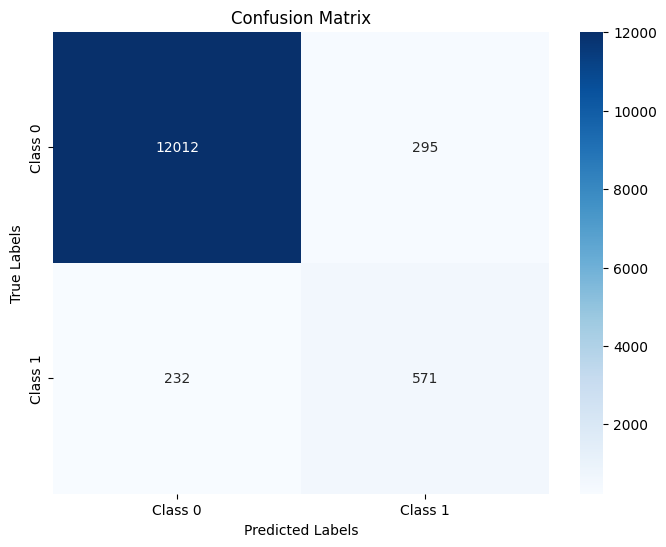

In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import UnidentifiedImageError

y_pred_labels = []
y_true_labels = []

for _ in range(test_it.samples // test_it.batch_size + 1):
    try:
        x_batch, y_true_batch = next(test_it)
        y_pred_batch = model_final.predict(x_batch)
        y_pred_labels_batch = np.argmax(y_pred_batch, axis=1)

        y_pred_labels.extend(y_pred_labels_batch)
        y_true_labels.extend(np.argmax(y_true_batch, axis=1))

    except UnidentifiedImageError as e:
        print(f"Skipped an image due to UnidentifiedImageError: {e}")

y_true_labels = np.array(y_true_labels)
y_pred_labels = np.array(y_pred_labels)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


## **Fine Tuning the layers**

### LAST CNN LAYER OF VGG16 to check its affect

In [23]:
model_2 = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height,3))

80134624/80134624 [==============================] - 0s 0us/step


In [24]:
for layer in model_2.layers:
    layer.trainable=False  
model_2.layers[-2].trainable=True    
model_final_2 = model_layers(model_2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [25]:
mcp_save_ = ModelCheckpoint('model_2.hdf5', save_best_only=True, monitor='accuracy', mode='max')

In [26]:
history=model_final_2.fit_generator(
train_it,
steps_per_epoch =150,
epochs=10,    
validation_data=valid_it,
validation_steps=150,
callbacks=[reduce_lr,mcp_save_])

/tmp/ipykernel_42/3800933179.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model_final_2.fit_generator(


Epoch 1/10
150/150 [==============================] - 144s 950ms/step - loss: 0.1887 - accuracy: 0.9381 - recall_1: 0.9392 - precision_1: 0.9392 - val_loss: 0.2007 - val_accuracy: 0.9333 - val_recall_1: 0.9458 - val_precision_1: 0.9224 - lr: 1.0000e-04
Epoch 2/10
150/150 [==============================] - 146s 973ms/step - loss: 0.1620 - accuracy: 0.9456 - recall_1: 0.9458 - precision_1: 0.9441 - val_loss: 0.1565 - val_accuracy: 0.9481 - val_recall_1: 0.9450 - val_precision_1: 0.9494 - lr: 1.0000e-04
Epoch 3/10
150/150 [==============================] - 137s 915ms/step - loss: 0.1507 - accuracy: 0.9458 - recall_1: 0.9442 - precision_1: 0.9475 - val_loss: 0.1262 - val_accuracy: 0.9544 - val_recall_1: 0.9533 - val_precision_1: 0.9559 - lr: 1.0000e-04
Epoch 4/10
150/150 [==============================] - 133s 886ms/step - loss: 0.1307 - accuracy: 0.9567 - recall_1: 0.9550 - precision_1: 0.9564 - val_loss: 0.1386 - val_accuracy: 0.9650 - val_recall_1: 0.9654 - val_precision_1: 0.9646 - lr:

In [47]:
model_final_2.load_weights('/kaggle/working/model_2.hdf5')

In [48]:
# score=model_final_2.evaluate_generator(test_it,steps=39997/128,workers=2, use_multiprocessing=True, verbose=0)
#score=model_final.evaluate_generator(test_it,steps=13142/128,workers=2, use_multiprocessing=True, verbose=0)
score = model_final_2.evaluate_generator(test_it, steps=len(test_it)//32, workers=2, use_multiprocessing=True, verbose=0)


/tmp/ipykernel_42/941046585.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model_final_2.evaluate_generator(test_it, steps=len(test_it)//32, workers=2, use_multiprocessing=True, verbose=0)


In [49]:
print("The accuracy for model-Pretrained vgg-16 fine-tuning the last CNN vgg layer:",score[1]*100,"%")
print("The recall for model-Pretrained vgg-16 fine-tuning the last CNN vgg layer:",score[2]*100,"%")
print("The precision for model-Pretrained vgg-16fine-tuning the last CNN vgg layer:",score[3]*100,"%")

The accuracy for model-Pretrained vgg-16 fine-tuning the last CNN vgg layer: 96.61458134651184 %
The recall for model-Pretrained vgg-16 fine-tuning the last CNN vgg layer: 96.61458134651184 %
The precision for model-Pretrained vgg-16fine-tuning the last CNN vgg layer: 96.86684012413025 %


### LAST 2 CNN LAYERS OF VGG-16

In [39]:
model_3 = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

In [40]:
for layer in model_3.layers:
    layer.trainable=False  
model_3.layers[-2].trainable=True
model_3.layers[-3].trainable=True      
model_final_3 = model_layers(model_3)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [41]:
mcp_save3 = ModelCheckpoint('model_final_3.hdf5', save_best_only=True, monitor='accuracy', mode='max')

In [42]:
history = model_final_3.fit_generator(
train_it,
steps_per_epoch = 150,
epochs=10,    
validation_data = valid_it,
validation_steps = 150,
callbacks=[reduce_lr,mcp_save3])

/tmp/ipykernel_42/587999042.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_final_3.fit_generator(


Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9312 - recall_2: 0.9298 - precision_2: 0.9321

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 126s 824ms/step - loss: 0.2057 - accuracy: 0.9312 - recall_2: 0.9298 - precision_2: 0.9321 - val_loss: 0.1670 - val_accuracy: 0.9394 - val_recall_2: 0.9421 - val_precision_2: 0.9390 - lr: 1.0000e-04
Epoch 2/10
150/150 [==============================] - 122s 817ms/step - loss: 0.1633 - accuracy: 0.9417 - recall_2: 0.9444 - precision_2: 0.9383 - val_loss: 0.1272 - val_accuracy: 0.9581 - val_recall_2: 0.9585 - val_precision_2: 0.9581 - lr: 1.0000e-04
Epoch 3/10
150/150 [==============================] - 123s 823ms/step - loss: 0.1472 - accuracy: 0.9521 - recall_2: 0.9523 - precision_2: 0.9513 - val_loss: 0.1270 - val_accuracy: 0.9588 - val_recall_2: 0.9596 - val_precision_2: 0.9588 - lr: 1.0000e-04
Epoch 4/10
150/150 [==============================] - 124s 826ms/step - loss: 0.1304 - accuracy: 0.9583 - recall_2: 0.9585 - precision_2: 0.9579 - val_loss: 0.1085 - val_accuracy: 0.9652 - val_recall_2: 0.9654 - val_precision_2: 0.9648 - lr: 1.0000e-04

In [ ]:
model_final_3.load_weights('/kaggle/working/model_final_3.hdf5')

In [43]:
score3 = model_final_3.evaluate(test_it, steps=len(test_it)//32, workers=2, use_multiprocessing=True)

12/12 [==============================] - 2s 152ms/step - loss: 0.0881 - accuracy: 0.9740 - recall_2: 0.9740 - precision_2: 0.9765


In [44]:
print("The accuracy for model-Pretrained vgg-16 fine-tuning the last 2 CNN vgg layer:",score3[1]*100,"%")
print("The recall for model-Pretrained vgg-16 fine-tuning the last 2 CNN vgg layer:",score3[2]*100,"%")
print("The precision for model-Pretrained vgg-16 fine-tuning the last 2 CNN vgg layer:",score3[3]*100,"%")


The accuracy for model-Pretrained vgg-16 fine-tuning the last 2 CNN vgg layer: 97.39583134651184 %
The recall for model-Pretrained vgg-16 fine-tuning the last 2 CNN vgg layer: 97.39583134651184 %
The precision for model-Pretrained vgg-16 fine-tuning the last 2 CNN vgg layer: 97.65012860298157 %


In [45]:
from prettytable import PrettyTable

x = PrettyTable()

# Set column names and alignment
x.field_names = ["MODEL", "TEST ACCURACY"]
x.align["MODEL"] = "l"  # Align the MODEL column to the left
x.align["TEST ACCURACY"] = "r"  # Align the TEST ACCURACY column to the right

# Add rows to the table
x.add_row(["VGG TRANSFER LEARNING WITH IMAGENET INITIALIZED WEIGHTS FINE TUNING ALL LAYERS", "89%"])
x.add_row(["FINE TUNING LAST LAYER OF VGG WITH IMAGENET INITIALIZED WEIGHTS", "85.23%"])
x.add_row(["FINE TUNING LAST 2 LAYERS OF VGG WITH IMAGENET INITIALIZED WEIGHTS", "86.60%"])

# Customize table appearance
x.title = "Model Performance Comparison"
x.horizontal_char = '-'
x.vertical_char = '|'

# Print the formatted table
print(x)


+------------------------------------------------------------------------------------------------+
|                                  Model Performance Comparison                                  |
+--------------------------------------------------------------------------------+---------------+
| MODEL                                                                          | TEST ACCURACY |
+--------------------------------------------------------------------------------+---------------+
| VGG TRANSFER LEARNING WITH IMAGENET INITIALIZED WEIGHTS FINE TUNING ALL LAYERS |           89% |
| FINE TUNING LAST LAYER OF VGG WITH IMAGENET INITIALIZED WEIGHTS                |        85.23% |
| FINE TUNING LAST 2 LAYERS OF VGG WITH IMAGENET INITIALIZED WEIGHTS             |        86.60% |
+--------------------------------------------------------------------------------+---------------+
